In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [19]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [38]:

# Load data
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')

# Merge datasets
df_train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

del train_transaction, train_identity

In [39]:
# Reduce memory usage
df_train = reduce_mem_usage(df_train)

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1206.83 Mb (52.0% reduction)


In [ ]:
for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype=='object': 
        lbl = LabelEncoder()
        df_train[f] = lbl.fit_transform(df_train[f])

df_train.fillna(-999, inplace=True)

In [42]:
percent_missing = (df_train == -999).mean() * 100

percent_missing_sorted= percent_missing.sort_values(ascending=False)
percent_missing_sorted

id_24         99.196159
id_25         99.130965
id_07         99.127070
id_08         99.127070
id_21         99.126393
                ...    
id_36          0.000000
id_37          0.000000
id_38          0.000000
DeviceType     0.000000
DeviceInfo     0.000000
Length: 433, dtype: float64

In [ ]:
percent_missing = (df_train == -999).mean() * 100

# Identify columns where more than 50% of the values are missing
cols_to_drop = percent_missing[percent_missing > 50].index

# Drop these columns
df_train_cleaned = df_train.drop(columns=cols_to_drop)

# Display the cleaned dataframe
print(f"Columns removed: {cols_to_drop}")
print(f"Shape of the cleaned dataframe: {df_train_cleaned.shape}")

Columns removed: Index(['dist1', 'dist2', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14',
       ...
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26', 'id_32'],
      dtype='object', length=192)
Shape of the cleaned dataframe: (590540, 241)


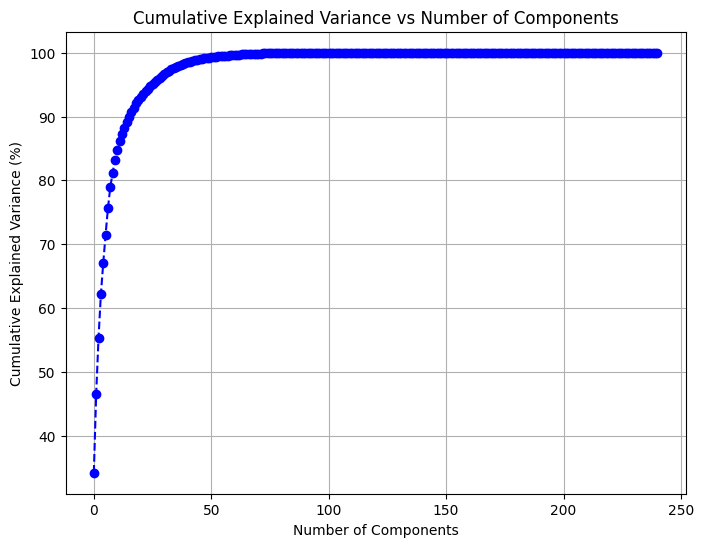

Number of components to retain for 95% explained variance: 38
Number of components with explained variance > 0.1%: 43


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train_cleaned)

# Compute the covariance matrix
cov_matrix = np.cov(X_scaled.T)  # Transpose to match the correct shape

# Calculate eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Sort the eigenvalues and their corresponding eigenvectors
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Total variance
tot = sum(eig_vals)

# Explained variance per component
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]

# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(8, 6))
plt.plot(cum_var_exp, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.grid(True)
plt.show()

# Optionally, decide how many components you want to retain, for example, you might choose 95% explained variance
n_components = np.argmax(cum_var_exp >= 98) + 1  # +1 because of 0-indexing
print(f"Number of components to retain for 95% explained variance: {n_components}")

# Filter components with variance greater than 0.1%
filtered_components = [(i, eig_pairs[i][1]) for i in range(len(var_exp)) if var_exp[i] > 0.1]


# Optionally, you can print out the number of components that were retained
print(f"Number of components with explained variance > 0.1%: {len(filtered_components)}")


Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 0.86
Validation F1 Score: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    113866
           1       0.99      0.86      0.92      4242

    accuracy                           0.99    118108
   macro avg       0.99      0.93      0.96    118108
weighted avg       0.99      0.99      0.99    118108



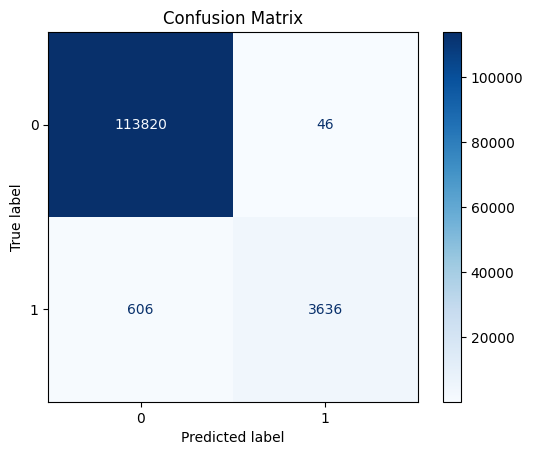

In [ ]:
X_train = df_train.select_dtypes(include=['number'])
y_train = df_train['isFraud']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_sub, y_train_sub)

# 7. Validate the model
y_val_pred = knn.predict(X_val)

# Show detailed classification report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')  # 'Blues' colormap for better readability
plt.title('Confusion Matrix')
plt.show()
